In [1]:
import pandas as pd  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm


In [108]:
pp_data = pd.read_csv("PowerProduction.csv", encoding = "cp1252")

In [109]:
pp_data['Year'] = pd.DatetimeIndex(pp_data['Date']).year
pp_data['Timestamp'] = pp_data['Timestamp'].apply(lambda x : pd.to_datetime(str(x)))
pp_data['Time'] = pp_data['Timestamp'].dt.time
#pp_data = pp_data.fillna(0)
pp_data['Date'] = pp_data['Date'].fillna("0")
pp_data['Total'] = pp_data['Total'].fillna("NAN")
pp_data.head()

,Unnamed: 0,Unit1,Unit2,Unit3,Unit4,Timestamp,Total,weekday,monthday,month,Date,week_num,Year,Time
0,1.0,363.397546,0.313414,0.022739,42.953678,2017-01-01 00:00:00,406.687378,sö,1.0,jan,01-01-2017,1.0,2017.0,00:00:00
1,2.0,364.341108,0.313414,0.022739,42.947920,2017-01-01 00:30:00,407.625181,sö,1.0,jan,01-01-2017,1.0,2017.0,00:30:00
2,3.0,365.150132,0.313414,0.022739,42.893757,2017-01-01 01:00:00,408.380043,sö,1.0,jan,01-01-2017,1.0,2017.0,01:00:00
3,4.0,365.208506,0.313414,0.022739,42.859928,2017-01-01 01:30:00,408.404587,sö,1.0,jan,01-01-2017,1.0,2017.0,01:30:00
4,5.0,366.165311,0.313414,0.022739,43.121319,2017-01-01 02:00:00,409.622783,sö,1.0,jan,01-01-2017,1.0,2017.0,02:00:00


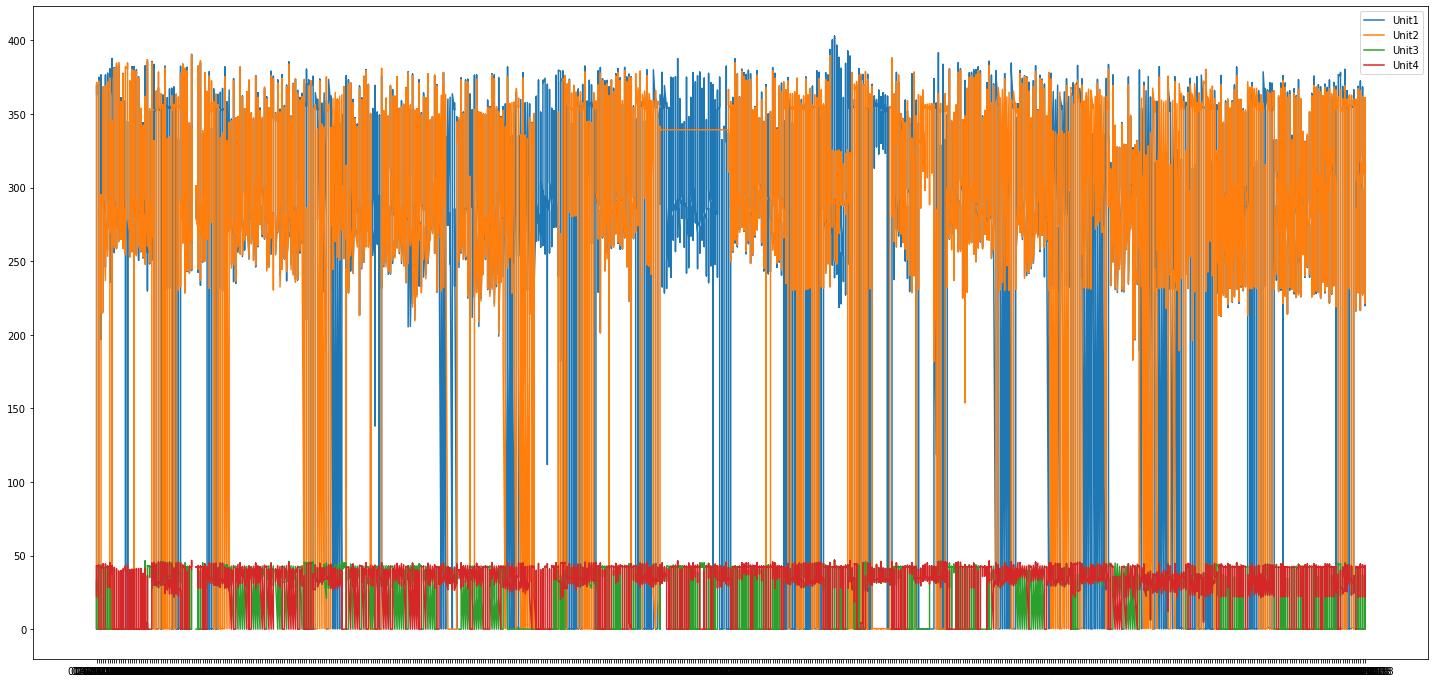

In [110]:
plt.figure(figsize=(25,12))
plt.plot(pp_data['Date'],pp_data['Unit1'],label = "Unit1")
plt.plot(pp_data['Date'],pp_data['Unit2'],label = "Unit2")
plt.plot(pp_data['Date'],pp_data['Unit3'],label = "Unit3")
plt.plot(pp_data['Date'],pp_data['Unit4'],label = "Unit4")
plt.legend()

# Question 1

The above plot shows the scatterness of the readings from all the 4 units against time of each day. Unit 1 and Unit 2 seems to have more readings between 250 - 400 and also drops to 0 at certain intervals. Wher as the Unit 3 and Unit 4 has low range values mostly between 0 and 50. Here also there are many values that drops to 0 at certain intervals. 

Hence clustering of readings from internal features that is the Unit readings can be difficult.

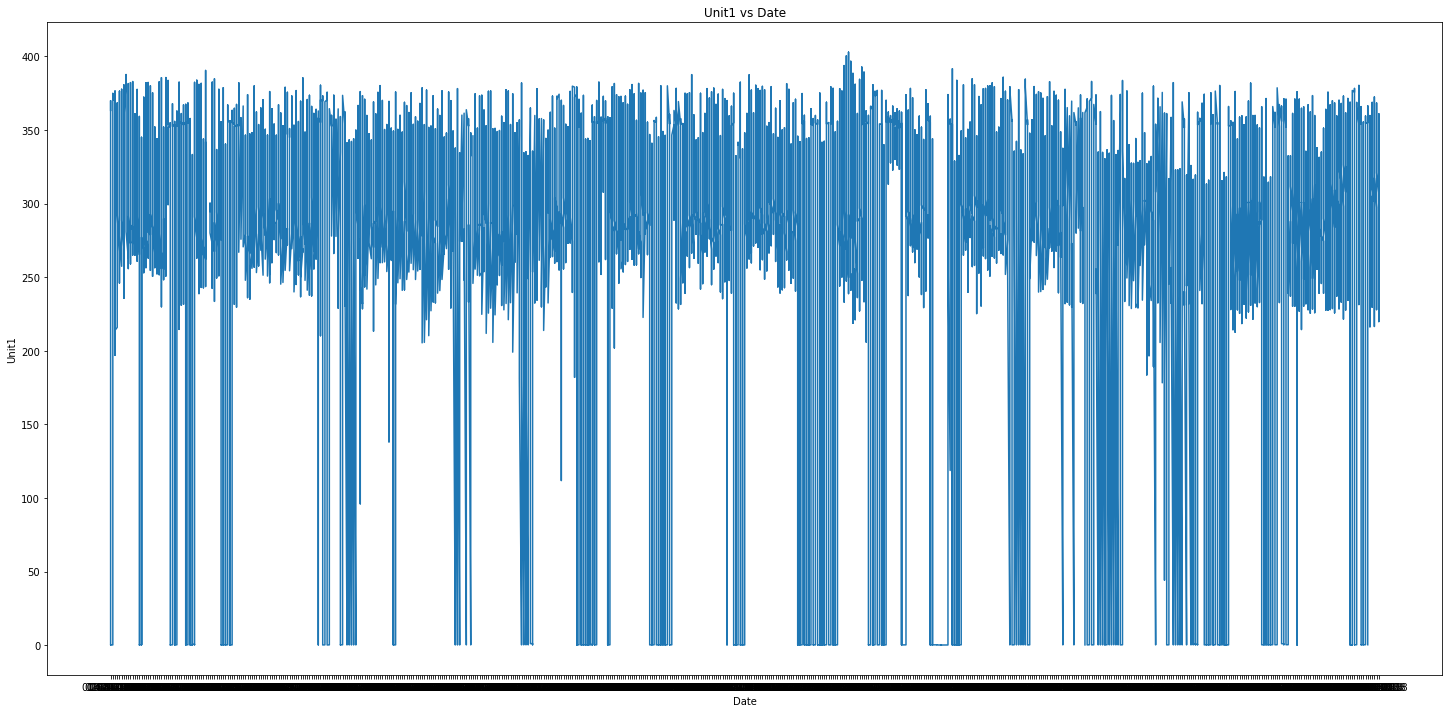

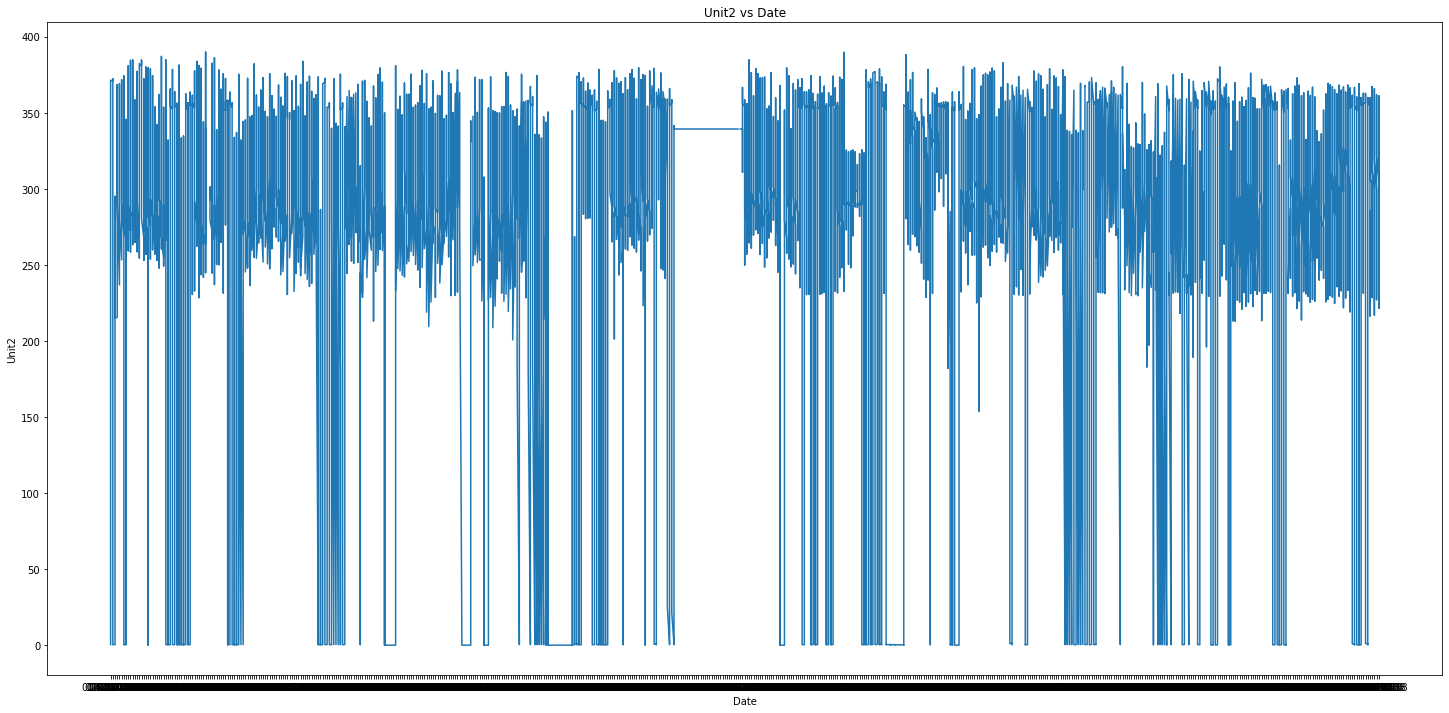

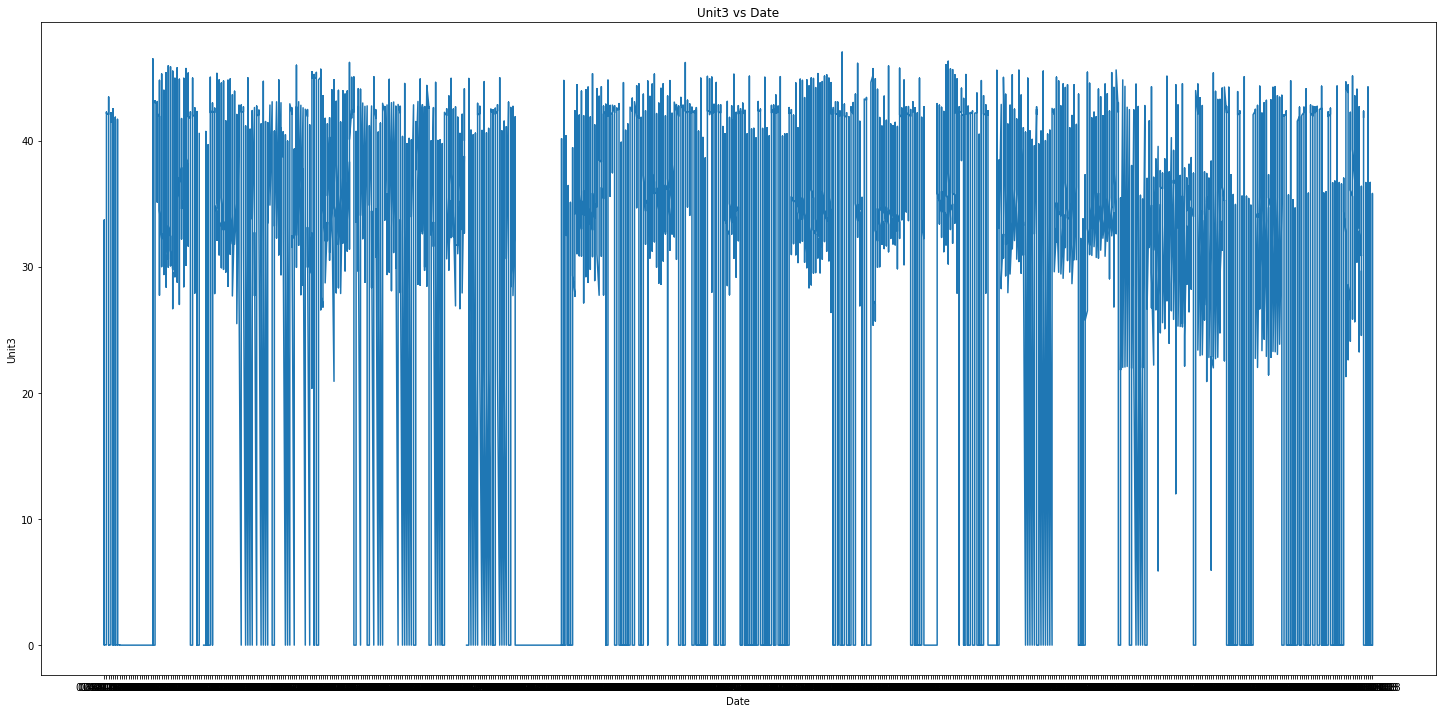

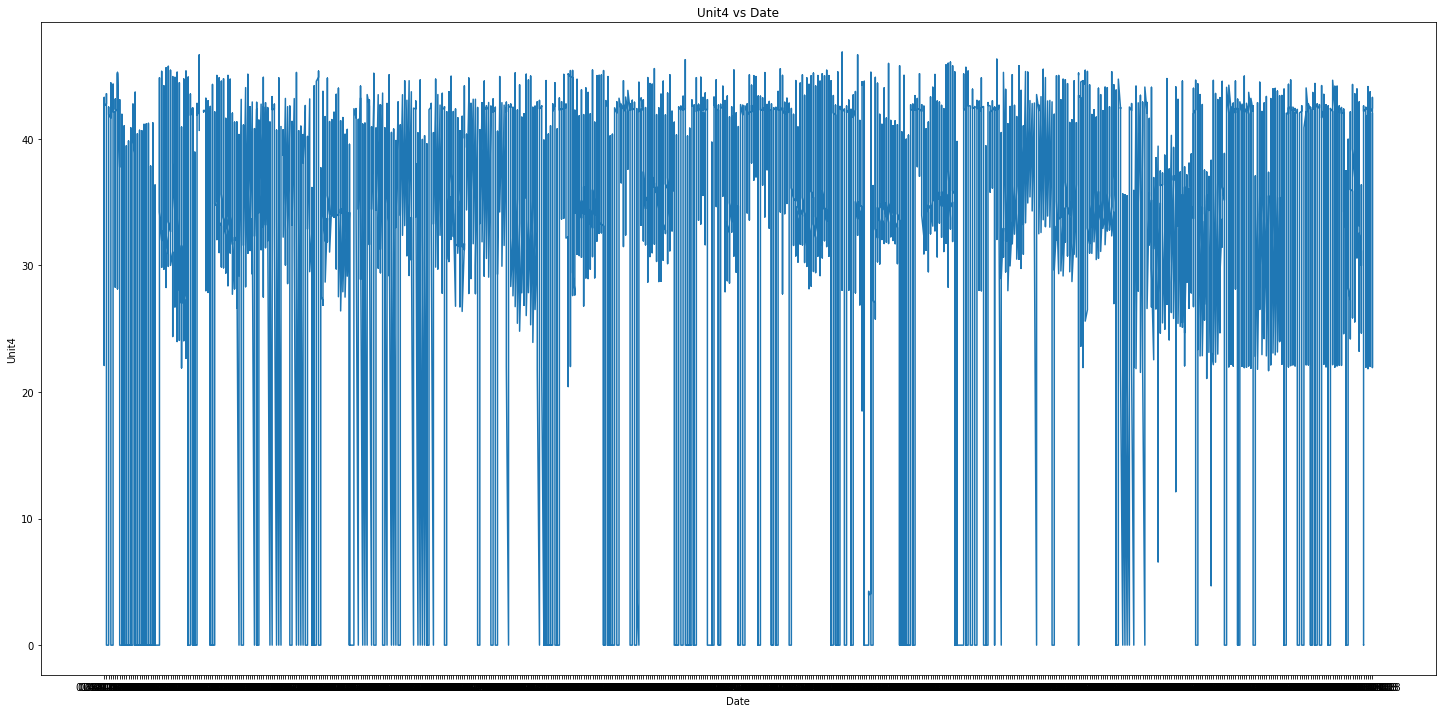

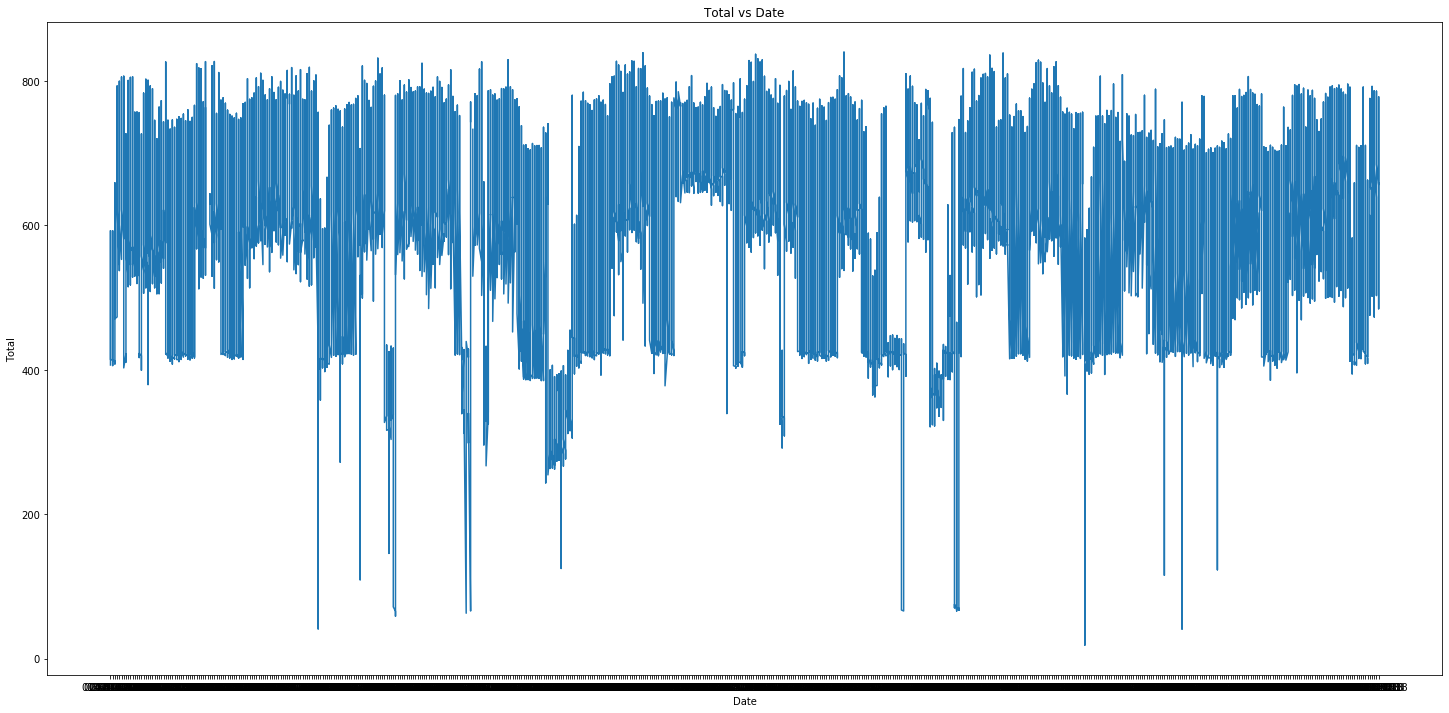

In [100]:
plt.figure(figsize=(25,12))
plt.plot(pp_data['Date'],pp_data['Unit1'])
plt.title('Unit1 vs Date')
plt.xlabel('Date')
plt.ylabel('Unit1')
plt.show()

plt.figure(figsize=(25,12))
plt.plot(pp_data['Date'],pp_data['Unit2'])
plt.title('Unit2 vs Date')
plt.xlabel('Date')
plt.ylabel('Unit2')
plt.show()

plt.figure(figsize=(25,12))
plt.plot(pp_data['Date'],pp_data['Unit3'])
plt.title('Unit3 vs Date')
plt.xlabel('Date')
plt.ylabel('Unit3')
plt.show()

plt.figure(figsize=(25,12))
plt.plot(pp_data['Date'],pp_data['Unit4'])
plt.title('Unit4 vs Date')
plt.xlabel('Date')
plt.ylabel('Unit4')
plt.show()

plt.figure(figsize=(25,12))
plt.plot(pp_data['Date'],pp_data['Total'])
plt.title('Total vs Date')
plt.xlabel('Date')
plt.ylabel('Total')
plt.show()

In [126]:
#ind = [i for i in range(len(pp_data['Total'])) if pp_data['Total'][i] is "NAN"]
#changepoint = [ind[i] for i in range(1,len(ind)) if ind[i] - ind[(i-1)] > 1]

Now we try to build a K means clustering to check how the readings are distributed.

In [111]:
from sklearn.cluster import KMeans
df_test = pp_data.iloc[:,:5]
df_test = df_test.fillna(0)
kmeans = KMeans(n_clusters=4,n_init = 4, random_state=0).fit(df_test)

In [113]:
df_test['labels'] = kmeans.labels_

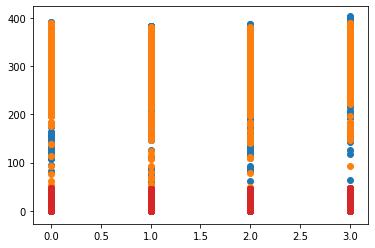

In [185]:
plt.scatter(df_test['labels'],df_test['Unit1'])
plt.scatter(df_test['labels'],df_test['Unit2'])
plt.scatter(df_test['labels'],df_test['Unit3'])
plt.scatter(df_test['labels'],df_test['Unit4'])


The above plot pretty much resembles the explaination given at first.

# Question 2

Change points basically corresponds to abrupt change in the readings of the data or the distribution of the data. Here in our Power Production Dataset we can see in Unit 2,3,4 there is sudden drop in readings to 0 which specifies the changepoints in the Time Series data.

# Question 3

The data has irregular breaks that is no readings were recorded frr certain number of days starting from rows 2085,3098,8191,14285,22080,28608.

Hence for the purpose of forecasting the time series for 24hrs, the training data has been limited to first 1500 rows, next 585 rows is been used as Validation data(Considering Supervised Learning) and the next 48 rows will be Predicted considering as Unsupervised learning.

The first model will be an Auto-Regressive Model with P order. 
In order to find best value for P for test time unsupervised learning, the MSE criterion is used. That is, best order is selected with minimal MSE during Training and Validation time and same order will be used to Forecast values for 24hrs.

Here, X is conisdered as "Time" from the given dataset and Y is considered as different internal features "Unit1","Unit2","Unit3","Unit4".

Since the reading from "Units" is recorded for every 0.5 Hrs, for computational easiness, the "Time" is reformed into range starting from 0 to 1042.5 having step size as 0.5.

Ultimately, the readings from each of the "Units" will be forecasted for 24hrs hours that is 48 values represented as "m" considering forecasting for every 0.5hrs.

The funtions used in this test is coded by myself as part of my academics, hence with little changes I have used the same.

In [155]:
def fit_ar(y, p):
    """Fits an AR(p) model. The loss function is the sum of squared errors from t=p+1 to t=n.

    :param y: array (n,), training data points
    :param p: int, AR model order
    :return theta: array (p,), learnt AR coefficients
    """

    # Number of training data points
    n = len(y)
    
    # Construct the regression matrix
    Phi = np.zeros(shape=(n-p, p))
    for j in range(p):
        Phi[:,j] = y[p-1-j:n-1-j]
        
        # Same as above but gives flipped theta
        #Phi[:,j] = y[j:n-p+j]
    
    # Drop the first p values from the target vector y
    yy = y[p:]  # yy = (y_{p+1}, ..., y_n)

    # Here we use fit_intercept=False since we do not want to include an intercept term in the AR model
    regr = lm.LinearRegression(fit_intercept=False)
    regr.fit(Phi,yy)

    return regr.coef_

In [174]:
def simulate_ar(y, theta, m):
    """Simulates an AR(p) model for m steps, with initial condition given by the last p values of y
    
    :param y: array (n,) with n>=p. The last p values are used to initialize the simulation.
    :param theta: array (p,). AR model parameters,
    :param m: int, number of time steps to simulate the model for.
    """

    p = len(theta)    
    y_sim = np.zeros(m)
    phi = np.flip(y[-p:].copy()) # (y_{n-1}, ..., y_{n-p})^T - note that y[ntrain-1] is the last training data point
    
    for i in range(m):
        # Make the one-step ahead prediction
        y_sim[i] = np.dot(theta, phi) # add np.random.normal(0,1)
        
        # Add the prediction to last p observations and remove the 
        phi = np.concatenate([y_sim[i:i+1], phi[:-1]])
    
    return y_sim

At first we find the Optimal order p for length of Validation data steps(m), so that the resulting p can be used for predicting Unsupervised data. The optimal order p is usually identifed by a plot which resembles Hockey Stick shape. That is we choose the order p for a point which have had a significant drop in MSE.

In [190]:

def opt_order(y_train):
    mse_valid = list()
    for p in range(2, 151):
    # Fit an AR model of order p using simple linear regression
        theta = fit_ar(y_train, p)
    
    # Make m-step predictions from the data
        y_pred = simulate_ar(y_train, theta, m=len(y_valid))
    
    # Compute the residuals
        residuals = y_valid-y_pred
    
    # Compute the validation mean-squared errors
        mse_valid.append(np.sum(residuals ** 2) / len(residuals)) # nvalid
        # Plot the training and validation MSE for different model orders
    plt.figure(figsize=(12,7))
    plt.title('Validation MSE using m-step predictions')
    plt.plot(range(2,151), mse_valid)
    plt.xlabel('Model Order p')
    plt.ylabel('Validation MSE')
    
    

# 24hrs Forecasting for Unit 1 Feature

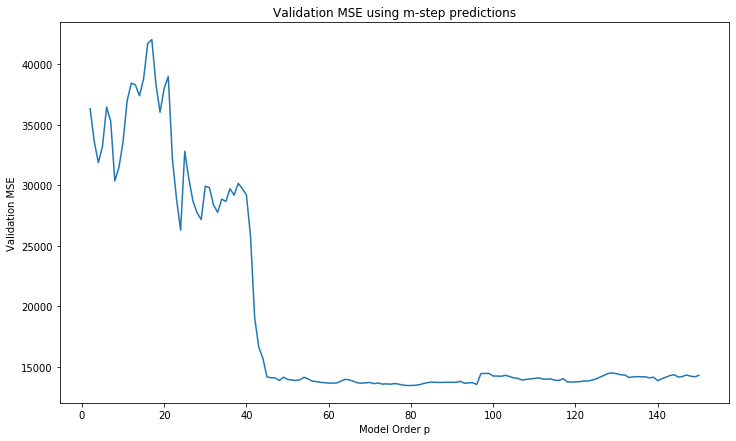

In [201]:
X = pp_data['Time'][:2085]
X = np.arange(0,1042.5,0.5).reshape(2085, 1)
y = pp_data['Unit1'][:2085] 

X_train = X[0:1500]
y_train = y[0:1500]

X_valid = X[1500:]
y_valid = y[1500:]

opt_order(y_train)

In [202]:
# From the above plot, Optimal P is found to be 45

p = 45
theta = fit_ar(y_train, p)
y_pred1 = simulate_ar(y_train, theta, m=48)
print("The 24hrs Forecasting for Unit1 starting from 2085 row in Original Data set is \n:", y_pred1)

The 24hrs Forecasting for Unit1 starting from 2085 row in Original Data set is 
: [345.28763421 342.97577418 337.30796401 336.37600485 337.09938937
 334.62650441 331.72557329 321.67663351 331.21907617 323.72425584
 322.79370672 320.82148381 317.74640038 323.55971774 326.63792745
 325.94088579 325.07920797 322.2717513  320.53159672 321.93268016
 325.5483707  329.50746224 325.9116946  326.39970021 327.43079794
 318.52522712 311.04705041 313.90683451 314.38966808 313.73356295
 313.43826705 311.77775266 314.93885394 313.74894383 312.08806329
 310.79473826 308.80534203 309.48003255 309.00106057 308.2465148
 308.18851001 308.51625662 309.58843073 311.52424419 312.13332815
 312.07678865 312.75700067 315.36011451]


 # 24hrs Forecasting for Unit 2 Feature

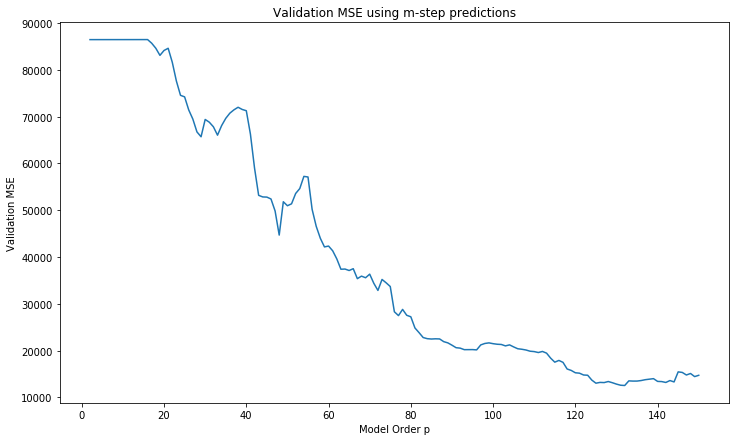

In [203]:
X = pp_data['Time'][:2085]
X = np.arange(0,1042.5,0.5).reshape(2085, 1)
y = pp_data['Unit2'][:2085] 

X_train = X[0:1500]
y_train = y[0:1500]

X_valid = X[1500:]
y_valid = y[1500:]

opt_order(y_train)

In [204]:
# From the above plot, Optimal P is found to be 80

p = 80
theta = fit_ar(y_train, p)
y_pred2 = simulate_ar(y_train, theta, m=48)
print("The 24hrs Forecasting for Unit2 starting from 2085 row in Original Data set is \n:", y_pred2)

The 24hrs Forecasting for Unit2 starting from 2085 row in Original Data set is 
: [ 15.02035139  32.72175642  46.81199015  58.30389305  72.79194601
  92.26882843 123.30906101 127.30517049 139.16056474 156.36868489
 167.31808323 170.60875267 181.10620393 169.87889551 178.63430702
 187.38607149 190.10096841 189.10963616 194.79237922 199.77744389
 196.65936155 192.06935652 189.79102273 199.45841431 226.69727573
 254.63581879 272.31706346 269.15266688 262.27235601 262.42841396
 275.00113395 281.23774372 252.06530797 244.0976206  241.57361638
 240.6042054  228.1057828  219.85994713 231.4798073  263.55852588
 271.18237356 273.57412082 269.67373495 261.39809784 259.11737568
 254.54994875 246.47614557 230.50060894]


# 24hrs Forecasting for Unit 3 Feature

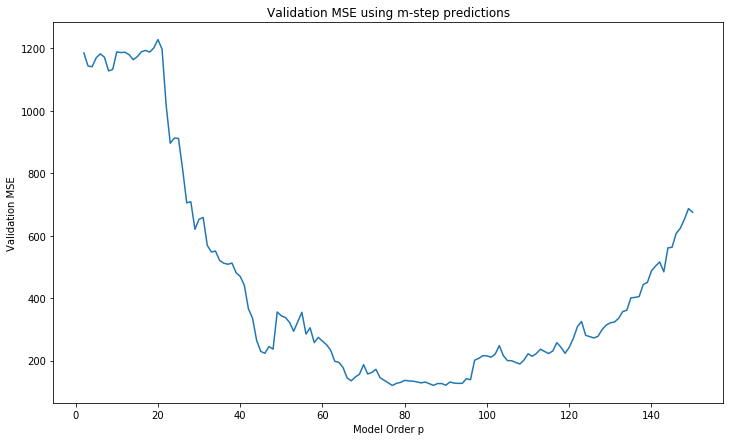

In [205]:
X = pp_data['Time'][:2085]
X = np.arange(0,1042.5,0.5).reshape(2085, 1)
y = pp_data['Unit3'][:2085] 

X_train = X[0:1500]
y_train = y[0:1500]

X_valid = X[1500:]
y_valid = y[1500:]

opt_order(y_train)

In [206]:
# From the above plot, Optimal P is found to be 68

p = 68
theta = fit_ar(y_train, p)
y_pred3 = simulate_ar(y_train, theta, m=48)
print("The 24hrs Forecasting for Unit3 starting from 2085 row in Original Data set is \n:", y_pred3)

The 24hrs Forecasting for Unit3 starting from 2085 row in Original Data set is 
: [29.51833261 30.47485803 29.93417888 30.76809389 32.43359668 34.96784892
 33.6789175  32.85222431 34.19525506 34.9704115  35.00313441 34.67356409
 32.33070134 32.91114288 32.81615221 32.7348218  31.79648654 31.76480939
 32.10640327 33.57890409 35.21669752 34.75675314 34.15115261 34.74236435
 36.27187444 35.67100969 35.30454689 35.44958993 35.61708731 35.25840885
 35.44260035 33.46691897 34.40220813 34.26946815 33.77392401 33.5133389
 33.01947557 33.61584416 35.82000727 35.64207116 36.09354199 35.73479685
 35.9133504  36.50153065 35.9284385  35.00365605 33.97260629 33.76081207]


# 24hrs Forecasting for Unit 4 Feature

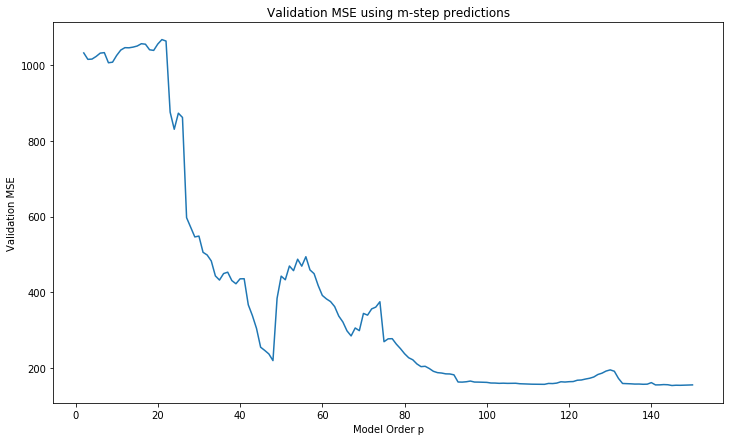

In [207]:
X = pp_data['Time'][:2085]
X = np.arange(0,1042.5,0.5).reshape(2085, 1)
y = pp_data['Unit4'][:2085] 

X_train = X[0:1500]
y_train = y[0:1500]

X_valid = X[1500:]
y_valid = y[1500:]

opt_order(y_train)

In [208]:
# From the above plot, Optimal P is found to be 48

p = 48
theta = fit_ar(y_train, p)
y_pred4 = simulate_ar(y_train, theta, m=48)
print("The 24hrs Forecasting for Unit4 starting from 2085 row in Original Data set is \n:", y_pred4)

The 24hrs Forecasting for Unit4 starting from 2085 row in Original Data set is 
: [28.91898485 27.70531244 29.11238157 28.07403851 27.85733307 32.69782817
 32.61857385 31.36102138 32.79413995 36.58746546 35.86668953 35.42193552
 35.7340224  36.79942464 36.61030558 37.20324828 37.06981152 37.12162474
 37.10168683 37.31269283 37.19117801 36.95626873 36.91142907 37.29536225
 37.41516349 37.35421505 37.58173987 36.95175181 36.28552754 37.01782031
 36.58296446 33.67594043 33.51151278 34.31463746 33.66459097 31.73263827
 31.91310937 31.7788022  31.48382993 31.10145237 31.09213693 30.69947064
 30.67242459 30.54394309 30.70162652 30.42111679 29.69666514 29.84140816]


In [211]:
Ytotal = y_pred1 + y_pred2 + y_pred3 + y_pred4
print("The 24hrs Forecasting for Total Units starting from 2085 row in Original Data set is \n:", Ytotal)

The 24hrs Forecasting for Total Units starting from 2085 row in Original Data set is 
: [418.74530306 433.87770106 443.1665146  453.5220303  470.18226512
 494.56100993 521.33212566 513.19504969 537.36903593 551.65081769
 560.98161388 561.52573609 566.91732805 563.14918077 574.69869225
 583.26502736 584.04647444 580.26782159 584.53206604 592.60172097
 594.61560779 593.28984062 586.76529901 597.89584111 627.8151116
 646.18627064 656.25040063 655.46084313 648.56463894 648.43820606
 660.46496581 660.15835578 634.91788283 626.43067005 621.10019466
 616.64492083 601.84370976 594.73462604 607.78470507 638.54856421
 646.5565625  648.52464493 645.84794068 639.96781576 637.88076885
 632.05151025 622.90241767 609.46294368]


In [310]:
#! pip install statsmodels

# Question 4

# 2nd Model

Now we build a SARIMA model to forecast the readings from all Units for 24 Hrs. Sarima Model has an edge over AR Model since it takes into consideration of the Seasonality Pattern as well as the Moving Average helps in better estimating the dependence of errors at each time step.

All the first 2085 rows has been considered as Train data.

Below the order of the Model is picked from analysing the ACF and PACF plots.

In [311]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf,pacf

# Forecasting using SARIMA for Unit 1

C:\Users\shvar\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:669: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,
C:\Users\shvar\miniconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  del sys.path[0]


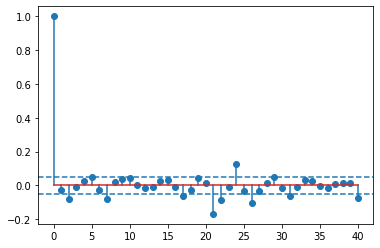

C:\Users\shvar\miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


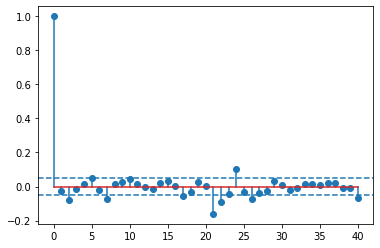

In [336]:
X = pp_data['Time'][:2085]
X = np.arange(0,1042.5,0.5).reshape(2085, 1)
y = pp_data['Unit1'][:2085] 

# Differenced Data
log_traindiff = y.diff(periods = 1).values[1:]

# ACF and PACF Calculation
lag_acf = acf(log_traindiff,nlags = 40)
lag_pacf = pacf(log_traindiff,nlags = 40)

# Plotting ACF
plt.stem(lag_acf)
plt.axhline(y=-1.96/np.sqrt(len(y_train)),linestyle = "--")
plt.axhline(y=1.96/np.sqrt(len(y_train)),linestyle = "--")
plt.show()


# Plotting PACF
plt.stem(lag_pacf)
plt.axhline(y=-1.96/np.sqrt(len(y_train)),linestyle = "--")
plt.axhline(y=1.96/np.sqrt(len(y_train)),linestyle = "--")
plt.show()

In [340]:
# From the above both the plots I have taken order p and q to be 7 and seasonal S as 24

model = SARIMAX(y, order = (7,1,7), seasonal_order = (1,0,0,24), enforce_stationarity = False, enforce_invertability = False)
model_fit = model.fit(disp = False)
K = 48
forecast1 = model_fit.forecast(K).tolist()
print("The 24hrs Forecasting for Unit1 starting from 2085 row in Original Data set using SARIMA is \n:", forecast1)

C:\Users\shvar\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The 24hrs Forecasting for Unit1 starting from 2085 row in Original Data set using SARIMA is 
: [338.26275941638374, 343.11923745580043, 337.6748605922841, 318.546494023713, 317.00065062001937, 335.07936104972, 346.9823556729074, 346.8572176305653, 342.88926920885757, 343.99896068203293, 355.9708152796576, 359.56860690685306, 341.41025479835935, 326.56218788695566, 326.62239697292836, 332.0372504150096, 335.5287490535847, 329.4315619498942, 326.2959533784751, 342.9712919919773, 351.92223766327356, 352.58471027881467, 344.1747411415475, 334.4881519882055, 335.87913772068464, 339.27973029637883, 330.6081023369742, 315.45383846182045, 314.2524874624502, 328.98852019028743, 342.2841196260474, 343.2783609322045, 338.0615220116737, 340.68160297566607, 351.5111113281432, 352.93601396249994, 337.6682851986309, 321.37146322155394, 319.47029398102364, 327.86827902071, 331.39943890794046, 325.49842085956993, 323.6369345112394, 336.59845833947725, 353.8100201159805, 355.78086692018456, 343.90526027

# Forecasting using SARIMA for Unit 2

C:\Users\shvar\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:669: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,
C:\Users\shvar\miniconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  del sys.path[0]


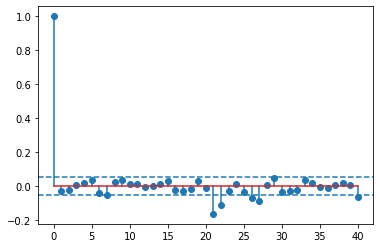

C:\Users\shvar\miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


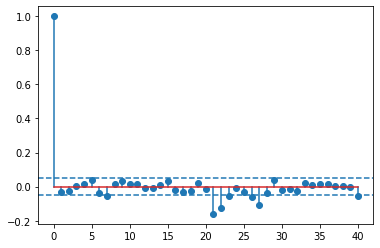

In [342]:
X = pp_data['Time'][:2085]
X = np.arange(0,1042.5,0.5).reshape(2085, 1)
y = pp_data['Unit2'][:2085] 

# Differenced Data
log_traindiff = y.diff(periods = 1).values[1:]

# ACF and PACF Calculation
lag_acf = acf(log_traindiff,nlags = 40)
lag_pacf = pacf(log_traindiff,nlags = 40)

# Plotting ACF
plt.stem(lag_acf)
plt.axhline(y=-1.96/np.sqrt(len(y_train)),linestyle = "--")
plt.axhline(y=1.96/np.sqrt(len(y_train)),linestyle = "--")
plt.show()


# Plotting PACF
plt.stem(lag_pacf)
plt.axhline(y=-1.96/np.sqrt(len(y_train)),linestyle = "--")
plt.axhline(y=1.96/np.sqrt(len(y_train)),linestyle = "--")
plt.show()

In [343]:
# From the above both the plots I have taken order p and q to be 7 and seasonal S as 21

model = SARIMAX(y, order = (7,1,7), seasonal_order = (1,0,0,21), enforce_stationarity = False, enforce_invertability = False)
model_fit = model.fit(disp = False)
K = 48
forecast2 = model_fit.forecast(K).tolist()
print("The 24hrs Forecasting for Unit1 starting from 2085 row in Original Data set using SARIMA is \n:", forecast2)

C:\Users\shvar\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The 24hrs Forecasting for Unit1 starting from 2085 row in Original Data set using SARIMA is 
: [338.867482093942, 341.7199124492112, 337.33886569114406, 318.22133690202827, 315.0763934285871, 336.37311868296393, 345.73537943244685, 342.75452683102, 340.9339917548073, 340.90203899940946, 355.7125591514608, 361.6068939031991, 338.37268666902025, 321.3014382270924, 324.3306530497354, 332.14681104073054, 338.8620606976216, 316.1038363545161, 311.1873658417875, 331.5505836502454, 348.8944352771418, 346.94733339637037, 333.4322184917107, 327.70117151588937, 331.21776970116497, 335.29605706273117, 326.68016650220295, 310.36098142349294, 309.963088820497, 326.4829240439412, 337.5551370240156, 334.74160049676726, 329.40116624386366, 333.304340785989, 345.0129058304367, 347.1177795997067, 330.7545856147745, 314.9620023367715, 319.01249294414254, 327.49726642831325, 328.19290541049673, 321.6166198619999, 319.05344315123045, 332.2470565417272, 348.46057550781495, 348.06679293829416, 335.9181727980

# Forecasting using SARIMA for Unit 3

C:\Users\shvar\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:669: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,
C:\Users\shvar\miniconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  del sys.path[0]


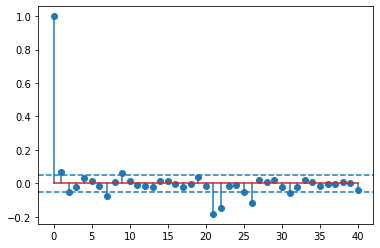

C:\Users\shvar\miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


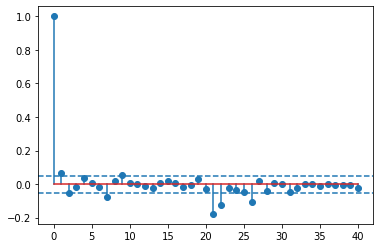

In [344]:
X = pp_data['Time'][:2085]
X = np.arange(0,1042.5,0.5).reshape(2085, 1)
y = pp_data['Unit3'][:2085] 

# Differenced Data
log_traindiff = y.diff(periods = 1).values[1:]

# ACF and PACF Calculation
lag_acf = acf(log_traindiff,nlags = 40)
lag_pacf = pacf(log_traindiff,nlags = 40)

# Plotting ACF
plt.stem(lag_acf)
plt.axhline(y=-1.96/np.sqrt(len(y_train)),linestyle = "--")
plt.axhline(y=1.96/np.sqrt(len(y_train)),linestyle = "--")
plt.show()


# Plotting PACF
plt.stem(lag_pacf)
plt.axhline(y=-1.96/np.sqrt(len(y_train)),linestyle = "--")
plt.axhline(y=1.96/np.sqrt(len(y_train)),linestyle = "--")
plt.show()

In [345]:
# From the above both the plots I have taken order p and q to be 1 and seasonal S as 21

model = SARIMAX(y, order = (1,1,1), seasonal_order = (1,0,0,21), enforce_stationarity = False, enforce_invertability = False)
model_fit = model.fit(disp = False)
K = 48
forecast3 = model_fit.forecast(K).tolist()
print("The 24hrs Forecasting for Unit1 starting from 2085 row in Original Data set using SARIMA is \n:", forecast3)

The 24hrs Forecasting for Unit1 starting from 2085 row in Original Data set using SARIMA is 
: [41.98366269166083, 41.56116432035939, 41.68637288761844, 41.649266980519265, 41.66026341927576, 41.65700459407032, 41.65797035598241, 41.657684149754076, 41.65776896776575, 41.65774383171212, 41.657751280851514, 41.65774907327834, 41.65774972749879, 41.65774953361874, 41.657749591075635, 41.657749574048125, 41.65774957909427, 41.65774957759883, 41.65774957804201, 39.89205603304643, 34.21333986572209, 33.95166034122414, 34.02920979601255, 34.00622779942907, 34.01303857802712, 34.01102018484953, 34.01161834128065, 34.01144107595888, 34.01149360902994, 34.01147804070824, 34.01148265442367, 34.01148128713628, 34.0114816923357, 34.01148157225372, 34.01148160784035, 34.01148159729416, 34.01148160041955, 34.01148159949333, 34.01148159976782, 34.011481599686476, 34.33557414307308, 35.37790086565471, 35.425932067267865, 35.41169788710005, 35.41591622597655, 35.41466610951974, 35.41503658500816, 35.41

# Forecasting using SARIMA for Unit 4

C:\Users\shvar\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:669: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,
C:\Users\shvar\miniconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  del sys.path[0]


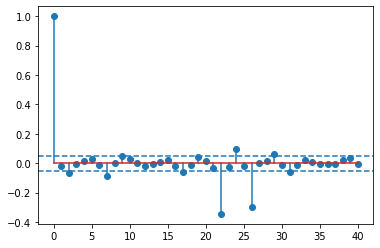

C:\Users\shvar\miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


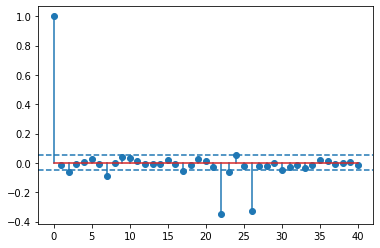

In [346]:
X = pp_data['Time'][:2085]
X = np.arange(0,1042.5,0.5).reshape(2085, 1)
y = pp_data['Unit4'][:2085] 

# Differenced Data
log_traindiff = y.diff(periods = 1).values[1:]

# ACF and PACF Calculation
lag_acf = acf(log_traindiff,nlags = 40)
lag_pacf = pacf(log_traindiff,nlags = 40)

# Plotting ACF
plt.stem(lag_acf)
plt.axhline(y=-1.96/np.sqrt(len(y_train)),linestyle = "--")
plt.axhline(y=1.96/np.sqrt(len(y_train)),linestyle = "--")
plt.show()


# Plotting PACF
plt.stem(lag_pacf)
plt.axhline(y=-1.96/np.sqrt(len(y_train)),linestyle = "--")
plt.axhline(y=1.96/np.sqrt(len(y_train)),linestyle = "--")
plt.show()

In [347]:
# From the above both the plots I have taken order p and q to be 2 and seasonal S as 23

model = SARIMAX(y, order = (2,1,2), seasonal_order = (1,0,0,23), enforce_stationarity = False, enforce_invertability = False)
model_fit = model.fit(disp = False)
K = 48
forecast4 = model_fit.forecast(K).tolist()
print("The 24hrs Forecasting for Unit1 starting from 2085 row in Original Data set using SARIMA is \n:", forecast4)

C:\Users\shvar\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The 24hrs Forecasting for Unit1 starting from 2085 row in Original Data set using SARIMA is 
: [41.07353324634061, 42.7059412480526, 43.13956374864345, 41.759133863602166, 40.57093154358443, 41.36617897537793, 42.93816849920279, 42.984409307548646, 41.41345348633791, 40.573233486037836, 41.69021747425426, 43.12776524722704, 42.738545013353054, 41.09401792483226, 40.66223976477417, 42.04548214417572, 43.228666620955025, 42.44005525459087, 40.83992110273823, 40.57536390280348, 42.13974618160807, 42.99404859030165, 42.17855929795611, 40.735573195077095, 41.032196220510706, 42.62817006032269, 43.15614652563607, 41.83698034907714, 40.625245815822915, 41.317741695543276, 42.885211433465834, 43.005668152442, 41.500881979601616, 40.60292083503332, 41.640670446217925, 43.075703919948346, 42.781738747473554, 41.194224420566925, 40.66852844717321, 41.980675037545204, 43.18584238214395, 42.49895754705112, 40.95170271611056, 40.83183096935664, 42.32766483373239, 43.20472281329876, 42.17313878707718

# Question 5

In [350]:
np.mean(y_pred1 - forecast1)

-16.599206635243036

In [351]:
np.mean(y_pred2 - forecast2)

-133.45701477770982

In [352]:
np.mean(y_pred3 - forecast3)

-3.3836206098852877

In [353]:
np.mean(y_pred4 - forecast4)

-8.17738988917771

From the above calculation we can see the average difference between the predictions from 1st Model(AR) and 2nd Model(SARIMA).

The reason for such difference could be because of consideration of seasonality and moving average errors in SARIMA model and also the choice of order of regression.

Amongst both the models, the first model that is Auto regressive model has better predictions since the predicted values are in the vicinity of their previous respective readings from respective Units.